# Customer Segmentation Report

## Goal:

The purpose of this analysis is to leverage unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. 

We'd like to identify the parts of the general population that are more likely to become part of Arvato future customer base. And, conversely, what parts of general population are less likely to become, and what features determine that.


# 00. Packages & Data
## a. Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from tqdm import tqdm
except:
    !pip install tqdm
    from tqdm import tqdm    
%matplotlib inline


### my utils
from sklearn.preprocessing import OrdinalEncoder
from unsupervised_utils import *

## b. Data

In [2]:
joint_dataset = pd.read_csv("../arvato_data_processed/joint_dataset_imputed.csv", low_memory = False, index_col = 'Unnamed: 0' )
joint_dataset

,WOHNLAGE,KBA13_KW_50,SEMIO_RAT,KBA05_SEG5,FINANZ_HAUSBAUER,FINANZTYP,GEMEINDETYP,KBA13_KRSHERST_AUDI_VW,D19_BUCH_RZ,KBA13_CCM_2500,...,KBA13_HALTER_65,D19_KONSUMTYP_MAX,SEMIO_ERL,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,GEBAEUDETYP,KBA13_CCM_3001,PRAEGENDE_JUGENDJAHRE_SIM,CAMEO_DEUINTL_2015_SIM
0,6.0,2.0,0.0,3.0,1.0,1.0,6.0,4.0,6.0,4.0,...,3.0,1.0,2.0,0.0,4.0,1.0,0.0,2.0,1.0,0.0
1,2.0,4.0,1.0,1.0,3.0,1.0,3.0,4.0,0.0,2.0,...,2.0,1.0,6.0,2.0,3.0,2.0,6.0,2.0,1.0,2.0
2,6.0,2.0,2.0,0.0,1.0,5.0,5.0,3.0,6.0,3.0,...,0.0,1.0,2.0,2.0,2.0,4.0,1.0,2.0,0.0,1.0
3,3.0,4.0,4.0,1.0,1.0,1.0,3.0,3.0,2.0,0.0,...,2.0,3.0,3.0,1.0,2.0,2.0,2.0,0.0,3.0,3.0
4,1.0,2.0,1.0,4.0,2.0,4.0,1.0,3.0,5.0,5.0,...,2.0,1.0,3.0,1.0,4.0,3.0,0.0,3.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932103,3.0,3.0,3.0,2.0,3.0,0.0,3.0,3.0,4.0,3.0,...,3.0,1.0,5.0,3.0,1.0,0.0,6.0,0.0,5.0,3.0
932104,5.0,0.0,3.0,0.0,2.0,5.0,2.0,3.0,0.0,3.0,...,3.0,4.0,6.0,2.0,2.0,2.0,6.0,3.0,4.0,4.0
932105,6.0,3.0,6.0,2.0,2.0,0.0,3.0,2.0,6.0,4.0,...,1.0,1.0,4.0,2.0,3.0,1.0,6.0,2.0,5.0,1.0
932106,5.0,4.0,4.0,1.0,4.0,0.0,1.0,1.0,6.0,1.0,...,2.0,4.0,1.0,2.0,1.0,1.0,6.0,0.0,5.0,4.0


# 01. Feature Scaling

All our our numerical and ordinal/categorical features are represented as numbers. The vast majority of features represent some notion of ordering (numerical/ordinal), while categorical features usually occur in a binary fashion 0/1.

So, I am going to later apply Principal Components Analysis (PCA) on this dataset. Although PCA is used for continuous variables, we might use PCA in this case as a simplified/naive case. As shown below:

[]

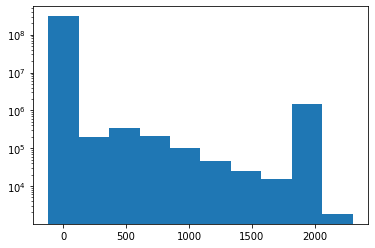

In [3]:
plt.hist(joint_dataset.to_numpy().reshape(-1),log=True)
plt.plot()

features are not standardizes. Some represent numerically the year, some represent a single ingerers (0,1,2,3,... etc). In order to treat each feature equally, regardless of the **scale** of the values it can take, I am going to apply a scikit-learn `StandardScaler`.

In [4]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

column_names = joint_dataset.columns
joint_dataset = ss.fit_transform(joint_dataset)

joint_dataset = pd.DataFrame(joint_dataset,columns=column_names)
joint_dataset

,WOHNLAGE,KBA13_KW_50,SEMIO_RAT,KBA05_SEG5,FINANZ_HAUSBAUER,FINANZTYP,GEMEINDETYP,KBA13_KRSHERST_AUDI_VW,D19_BUCH_RZ,KBA13_CCM_2500,...,KBA13_HALTER_65,D19_KONSUMTYP_MAX,SEMIO_ERL,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,GEBAEUDETYP,KBA13_CCM_3001,PRAEGENDE_JUGENDJAHRE_SIM,CAMEO_DEUINTL_2015_SIM
0,1.378786,-0.218516,-1.653814,1.303958,-0.761747,-0.915422,1.723457,1.015723,1.494956,1.048061,...,0.816326,-0.932765,-0.913706,-1.717709,1.829346,-1.071358,-0.686498,0.223500,-1.381526,-1.468939
1,-1.097921,1.175950,-1.050253,-0.431734,0.668244,-0.915422,0.147063,1.015723,-0.725020,-0.363154,...,-0.152763,-0.932765,1.286557,0.197449,0.861047,-0.071787,1.959536,0.223500,-1.381526,-0.111421
2,1.378786,-0.218516,-0.446692,-1.299580,-0.761747,1.044041,1.197992,0.020600,1.494956,0.342453,...,-2.090940,-0.932765,-0.913706,0.197449,-0.107252,1.927355,-0.245492,0.223500,-2.038541,-0.790180
3,-0.478744,1.175950,0.760430,-0.431734,-0.761747,-0.915422,0.147063,0.020600,0.014972,-1.774369,...,-0.152763,0.162547,-0.363641,-0.760130,-0.107252,-0.071787,0.195514,-1.102803,-0.067496,0.567337
4,-1.717097,-0.218516,-1.050253,2.171804,-0.046752,0.554175,-0.903867,0.020600,1.124960,1.753668,...,-0.152763,-0.932765,-0.363641,-0.760130,1.829346,0.927784,-0.686498,0.886652,-1.381526,-0.111421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932103,-0.478744,0.478717,0.156869,0.436112,0.668244,-1.405288,0.147063,0.020600,0.754964,0.342453,...,0.816326,-0.932765,0.736491,1.155028,-1.075551,-2.070929,1.959536,-1.102803,1.246535,0.567337
932104,0.759609,-1.612982,0.156869,-1.299580,-0.046752,1.044041,-0.378402,0.020600,-0.725020,0.342453,...,0.816326,0.710203,1.286557,0.197449,-0.107252,-0.071787,1.959536,0.886652,0.589520,1.246096
932105,1.378786,0.478717,1.967552,0.436112,-0.046752,-1.405288,0.147063,-0.974522,1.494956,1.048061,...,-1.121851,-0.932765,0.186425,0.197449,0.861047,-1.071358,1.959536,0.223500,1.246535,-0.790180
932106,0.759609,1.175950,0.760430,-0.431734,1.383240,-1.405288,-0.903867,-1.969644,1.494956,-1.068762,...,-0.152763,0.710203,-1.463772,0.197449,-1.075551,-1.071358,1.959536,-1.102803,1.246535,1.246096


[]

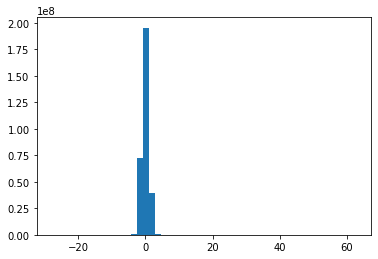

In [5]:
plt.hist(joint_dataset.to_numpy().reshape(-1),log=False,bins=50)
plt.plot()

we see now that jointly the values taken in our dataset resemble a Gaussian with mean 0 and standard deviation of 1. 

# 02. Correlation analysis and feature grouping:



In [8]:
%%time

corr_threshold=0.90

corr =  joint_dataset.corr()
corr_abs = corr.abs()
joint_dataset,corr_abs,deleted_columns,feature_correlated = remove_correlated(joint_dataset,corr_threshold, corr_matrix=corr_abs)

print("Removed {} columns that were above {} correlation threshold".format(len(deleted_columns),corr_threshold))

Removed 18 columns that were above 0.9 correlation threshold
CPU times: user 2min 27s, sys: 2.32 s, total: 2min 30s
Wall time: 2min 30s


For future reference we keep the names of the deleted columns in `deleted_columns` variable, and the columns for which they were highly correlated in a dictionary `feature_correlated` shown below:

In [11]:
feature_correlated

{'GEMEINDETYP': ['ORTSGR_KLS9'],
 'KBA13_KMH_211': ['KBA13_KMH_250'],
 'LP_LEBENSPHASE_FEIN': ['LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_GROB'],
 'LP_FAMILIE_GROB': ['LP_FAMILIE_FEIN'],
 'KBA13_GBZ': ['PLZ8_GBZ'],
 'D19_VERSAND_ONLINE_QUOTE_12': ['D19_GESAMT_ONLINE_QUOTE_12'],
 'LP_STATUS_FEIN': ['LP_STATUS_GROB'],
 'CAMEO_DEU_2015': ['CAMEO_DEUG_2015',
  'CAMEO_DEUINTL_2015',
  'CAMEO_DEUINTL_2015_SIM'],
 'KBA13_ALTERHALTER_61': ['KBA13_HALTER_66'],
 'ANZ_STATISTISCHE_HAUSHALTE': ['ANZ_HAUSHALTE_AKTIV'],
 'PLZ8_ANTG1': ['KBA13_ANTG1'],
 'PLZ8_HHZ': ['KBA13_HHZ'],
 'KBA13_HERST_SONST': ['KBA13_FAB_SONSTIGE'],
 'KBA13_BAUMAX': ['PLZ8_BAUMAX'],
 'PLZ8_ANTG3': ['KBA13_ANTG3'],
 'PRAEGENDE_JUGENDJAHRE': ['PRAEGENDE_JUGENDJAHRE_SIM']}

**For example** we see that `PLZ8_ANTG1` and `KBA13_ANTG1` are highly correlated features, from which `KBA13_ANTG1` was removed.

When looking back to **metadata descripton** `DIAS Attributes - Values 2017` we see that  `PLZ8_ANTG1` refers to "number of 1-2 family houses in the PLZ8", while for feature `KBA13_ANTG1` we lack any metadata description, and due to the common suffix they might refer to very similar feature.

Thus, we remove some 18 highly correlated features in this step of the analysis

Initial correlation matrix indicates that not many features are correlated with each other. I used `abs` to compute an absolute correlation coefficient. At this point we only care about the relative correlation, and not its directionality. 

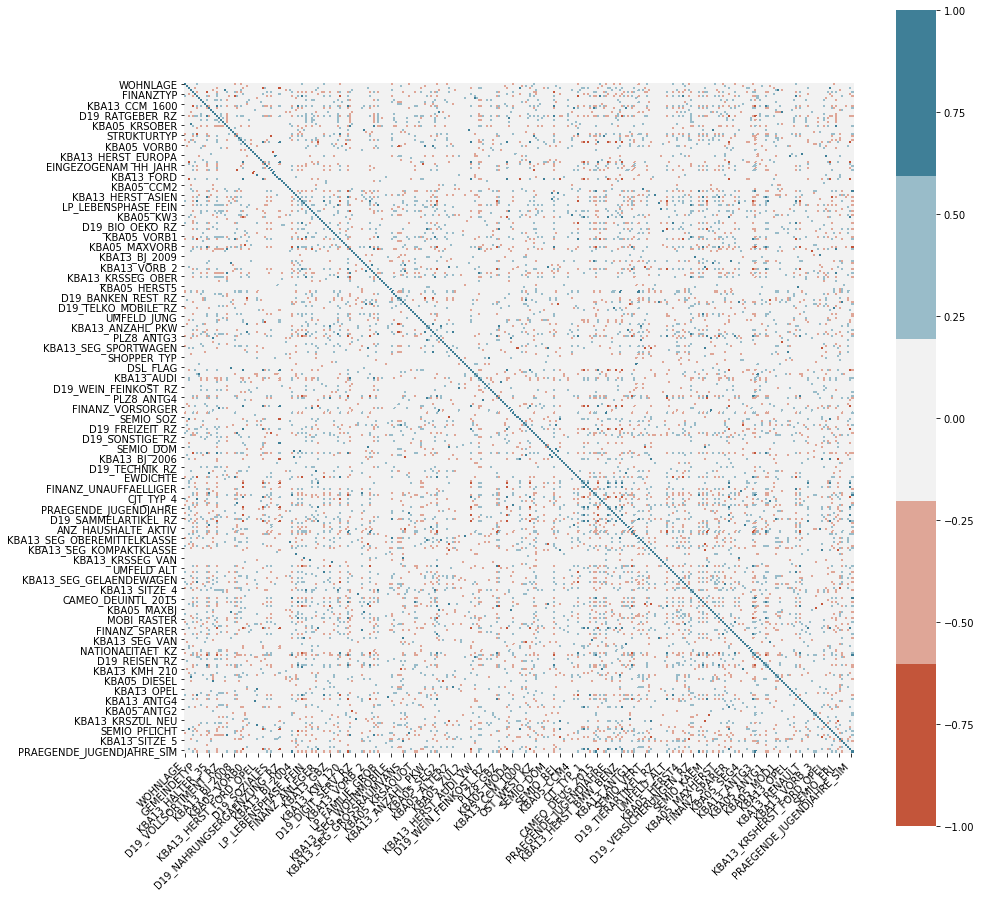

In [17]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 225, n=5),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# 02. Dimensionality reduction & Variance explained

As we want to cluster our data with many features, it would be beneficial to identifiy the redundancies in our dataset and redue the number of features to address the **curse of dimensionality** problem for clustering high dimensional data.

First. I will look over the variance explained by each features cumulatively, and compress the data so that it retains a significant portion of the variance explained. 

This 90% used below is an arbitrary threshold, a tradeoff between representing data accurately, and reducing the number of features. The compression is done by PCA: we identify ortogonal PC axes, that are a linear combination of features. As each PC is ordered by the importance (i.e. the amount of variance it explains), and we'll "trim" the last PC axes that contribute little to understand the dataset.



In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components= joint_dataset.shape[1])
joint_dataset_PCA = pca.fit_transform(joint_dataset)

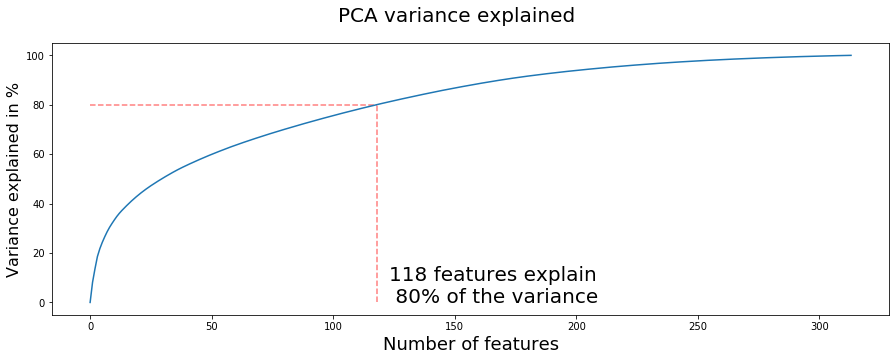

In [21]:
variance_explained(pca,80)

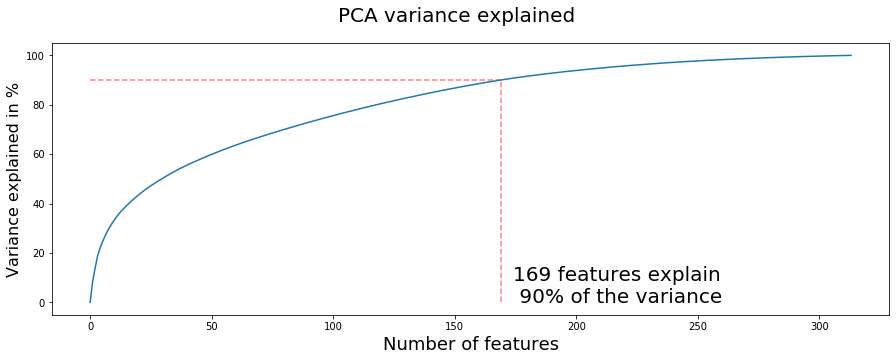

In [22]:
variance_explained(pca,90)

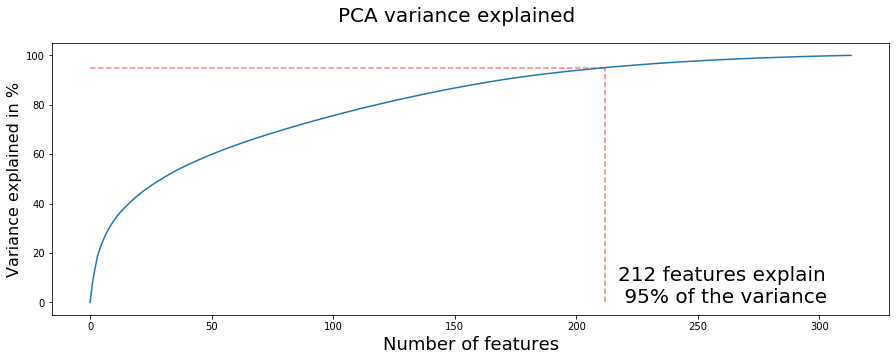

In [23]:
variance_explained(pca,95)

In [40]:
joint_dataset_PCA_reduced = joint_dataset_PCA[:,:169]
joint_dataset_PCA_reduced.shape

(932108, 169)

# 03. Clustering

- find optimal number of clusters
- show cluster distributions of azdias vs customers

- cluster centroids vs PCA

In [52]:

from sklearn.cluster import KMeans
from sklearn import metrics

def elbow_kmeans(X, clusters=10):
 
    sum_of_squared_distances = []
    silhouette_scores = []
    calinski_harabasz_scores = []

    for k in range(2,clusters+1):
        print("{}/{}".format(k,clusters))

        k_means = KMeans(n_clusters=k)
        k_means.fit(X)

        print("\t ...Fitted")
        labels = k_means.labels_


        # different metrics

        # Sil score takes too much time to compute
        #sil_score = metrics.silhouette_score(X, labels, metric = 'euclidean')
        #silhouette_scores.append(sil_score)
        #print("...Computed Silhouette score")

        CH_score = metrics.calinski_harabasz_score(X, labels)
        calinski_harabasz_scores.append(CH_score)
        print("\t Computed calinski harabasz score")

        sum_of_squared_distances.append(k_means.inertia_)
        print("\t Computed sum of squares distance score")
        
    return sum_of_squared_distances,calinski_harabasz_scores

In [ ]:
%%time
sum_of_squared_distances,calinski_harabasz_scores = elbow_kmeans(X=joint_dataset_PCA_reduced, clusters=25)

import pickle

with open('sum_of_squared_distances.pkl', 'wb') as pickle_file:
    pickle.dump(sum_of_squared_distances, pickle_file)

with open('calinski_harabasz_scores.pkl', 'wb') as pickle_file:
    pickle.dump(calinski_harabasz_scores, pickle_file)



2/25


# 03. Feature importance

In [31]:
joint_dataset_PCA.shape

(932108, 314)

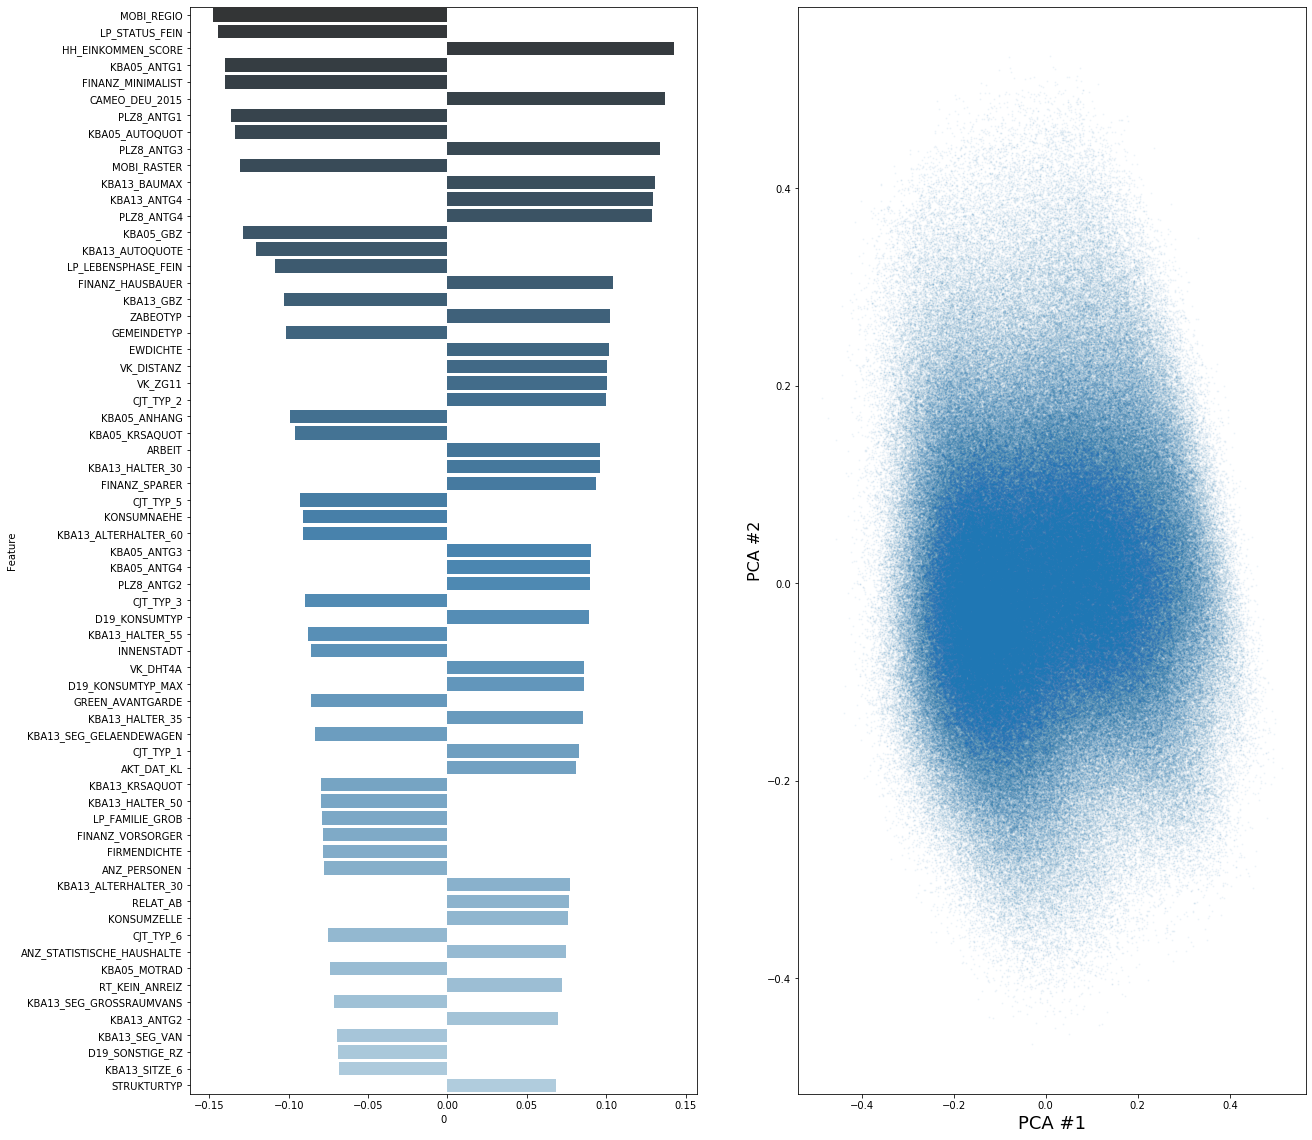

In [30]:
feature_importance_df = pca_explainer(pca = joint_dataset_PCA, 
                    pca_comonents = pca.components_, 
                    features_list = joint_dataset.columns, 
                    pca_num=1, 
                    n_weights=65,
                    alpha=0.05,
                    size=.9,
                    plot_arrows=False,
                    width=20,height=20)

# 03. Variance explained